In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import datetime
from sklearn import metrics
from scipy.stats import zscore
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
#Reading the csv file and data
df = pd.read_csv("worldometer_snapshots_April18_to_May18.csv")
df_age = pd.read_csv("population_structure_by_age_per_contry.csv")

In [3]:
#getting all columns name and checking null values
print(df.shape)
df.isnull().sum()

(6603, 9)


Date                      0
Country                   0
Population                0
Total Tests            1098
Total Cases              49
Total Deaths           1236
Total Recovered         285
Serious or Critical    2486
Active Cases             59
dtype: int64

In [4]:
#We can drop - Serious column as most of the rows are blank and this variable is not useful for our analysis
df.drop(columns=["Serious or Critical"],axis=1,inplace=True)
#also we can drop rows that are null in active/toal cases/total recovered
df.dropna(axis=0,how="any",subset=["Total Cases","Total Recovered","Active Cases"],inplace=True)


### Imputing missing values

In [5]:
#imputing missing values in total deaths columns
#Death = total case - active - recovered
df["Total Deaths"]=df["Total Cases"]-df["Active Cases"]-df["Total Recovered"]

In [6]:
#imputing missing values for total cases 
#Now grouping countries and imputing missing value
df['Total Tests'] = df['Total Tests'].fillna(df.groupby('Country')['Total Tests'].transform('median'))
df.isnull().sum()

Date                 0
Country              0
Population           0
Total Tests        751
Total Cases          0
Total Deaths         0
Total Recovered      0
Active Cases         0
dtype: int64

In [7]:
#Again imputing missing values for total cases as 0 for the rest of the countries
#Now grouping countries and imputing missing value
df['Total Tests'] = df['Total Tests'].fillna(0)
df["Death Rate"] = df["Total Deaths"]*100/df["Total Cases"]
df.isnull().sum()

Date               0
Country            0
Population         0
Total Tests        0
Total Cases        0
Total Deaths       0
Total Recovered    0
Active Cases       0
Death Rate         0
dtype: int64

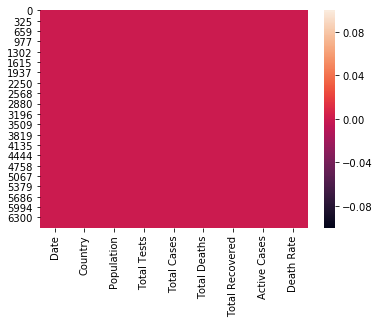

In [8]:
sns.heatmap(df.isnull())
plt.show()

##### Observation:
 
    No null values are present in the dataset.

In [9]:
#Checking the datatypes
df.dtypes

Date                object
Country             object
Population           int64
Total Tests        float64
Total Cases        float64
Total Deaths       float64
Total Recovered    float64
Active Cases       float64
Death Rate         float64
dtype: object

In [10]:
#changing Date into datetime format
df['Date'] =  pd.to_datetime(df['Date'],
                              format='%Y-%m-%d')

## DATA VISUALIZATION


### Correlation of True Death Rate with Number of Tests


In [11]:
#categorizing data with respect to unique provinces/states and creating a new table 

confirmed_by_Country = []
death_by_Country = [] 
active_by_Country = []
recovery_by_Country = []
death_rate_by_Country = [] 
total_tests_by_Country=[]
population_by_Country=[]

no_cases = []

unique_countries =  list(df['Country'].unique())

all_dates = df["Date"]
last_date = all_dates.iat[-1]
total_confirmed_cases =[]


for i in unique_countries:
    active_cases = df[df["Country"]==i]["Total Cases"].iloc[-1]
    recovered_cases = df[df["Country"]==i]["Total Recovered"].iloc[-1]
    death_cases = df[df["Country"]==i]["Total Deaths"].iloc[-1]
    death_rate = df[df["Country"]==i]["Death Rate"].iloc[-1]
    total_tests = df[df["Country"]==i]["Total Tests"].iloc[-1]
    population = df[df["Country"]==i]["Population"].iloc[-1]
    if active_cases> 0:
        confirmed_by_Country.append(i)
        active_by_Country.append(active_cases)
        death_by_Country.append(death_cases) 
        recovery_by_Country.append(recovered_cases)
        death_rate_by_Country.append(death_rate)
        population_by_Country.append(population)
        total_tests_by_Country.append(total_tests)
        total_confirmed = death_cases + recovered_cases + active_cases
        total_confirmed_cases.append(total_confirmed)
              
    else :
        no_cases.append(i)  

In [12]:
#Sort by death rate

Country_df = pd.DataFrame({'Country Name': confirmed_by_Country, 'Confirmed': total_confirmed_cases,
                          'Deaths': death_by_Country, 'Recovered' : recovery_by_Country, 
                          'Active Cases' : active_by_Country, "Death_Rate":death_rate_by_Country,"Total Tests":total_tests_by_Country,"Population":population_by_Country})
# cases per Country/region 

Country_df.style.background_gradient(cmap='Blues')
sorted = Country_df.sort_values('Death_Rate', ascending=False)
sorted.head(10).style.background_gradient(cmap='Blues')

,Country Name,Confirmed,Deaths,Recovered,Active Cases,Death_Rate,Total Tests,Population
170,Nicaragua,40,8,7,25,32,0,6615040
160,Sint Maarten,146,15,54,77,19.4805,414,42817
14,Belgium,79296,9080,14657,55559,16.343,696840,11583739
5,France,269894,28239,61728,179927,15.6947,1.38463e+06,65256826
201,Yemen,151,20,1,130,15.3846,120,29742981
4,Italy,385219,32007,127326,225886,14.1695,3.04137e+06,60471924
64,Hungary,5397,462,1400,3535,13.0693,137243,9663123
189,British Virgin Islands,15,1,6,8,12.5,167,30207
22,Sweden,39046,3698,4971,30377,12.1737,177500,10091856
171,Antigua and Barbuda,47,3,19,25,12,183,97833


##### Observations: 
1. Clearly many countries with less cases are showing very high death number.
2. To evaluate the situation better , we will consider countries with >5000 confirmed cases only.

In [13]:
#Plotting highest states w.r.t death rate where confirmed cases >5000
Country_df = Country_df[Country_df["Confirmed"]>5000]
sorted = Country_df.sort_values('Death_Rate', ascending=False)
sorted.head(10).style.background_gradient(cmap='Blues')

,Country Name,Confirmed,Deaths,Recovered,Active Cases,Death_Rate,Total Tests,Population
14,Belgium,79296,9080,14657,55559,16.343,696840,11583739
5,France,269894,28239,61728,179927,15.6947,1.38463e+06,65256826
4,Italy,385219,32007,127326,225886,14.1695,3.04137e+06,60471924
64,Hungary,5397,462,1400,3535,13.0693,137243,9663123
22,Sweden,39046,3698,4971,30377,12.1737,177500,10091856
15,Mexico,87725,5177,33329,49219,10.5183,172294,128770253
2,Spain,502855,27709,196958,278188,9.96053,3.03784e+06,46752703
19,Ecuador,39814,2799,3433,33582,8.33482,96536,17610231
48,Algeria,11381,555,3625,7201,7.70726,6500,43752773
12,Canada,123142,5842,39228,78072,7.48284,1.32337e+06,37702769


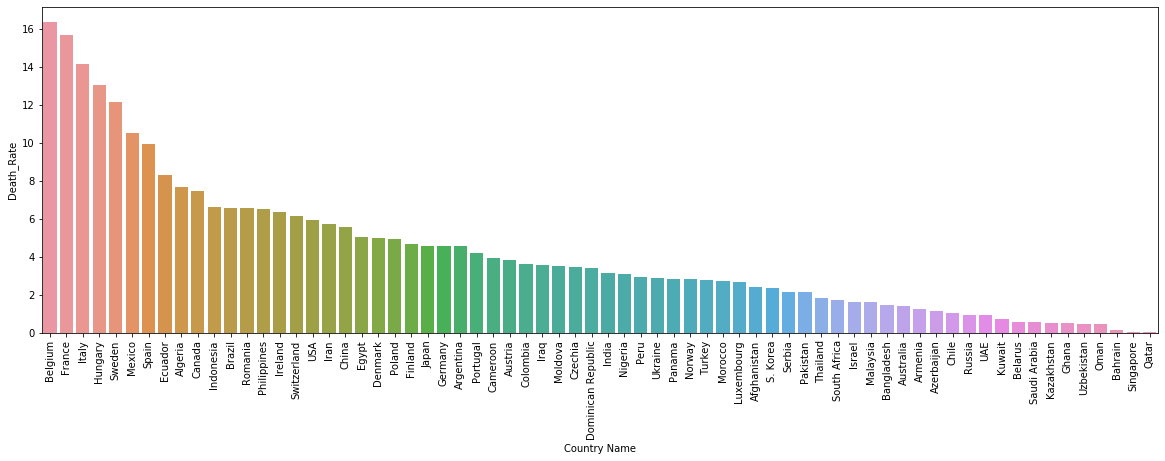

In [14]:
#plotting the values
plt.figure(figsize=(20,6))
sns.barplot(x ="Country Name", y="Death_Rate", data=sorted)
plt.xticks(rotation=90)
plt.show()

##### Observations: 
1. We can observe that death rate varies from 16 % to 0.5% for most of the countries.
2. Highest Death rate is shown by Belgium, France and Italy. 
3. Lowest Death Rate is shown by Qatar, Singapore, Bahrain.

(-1, 30)

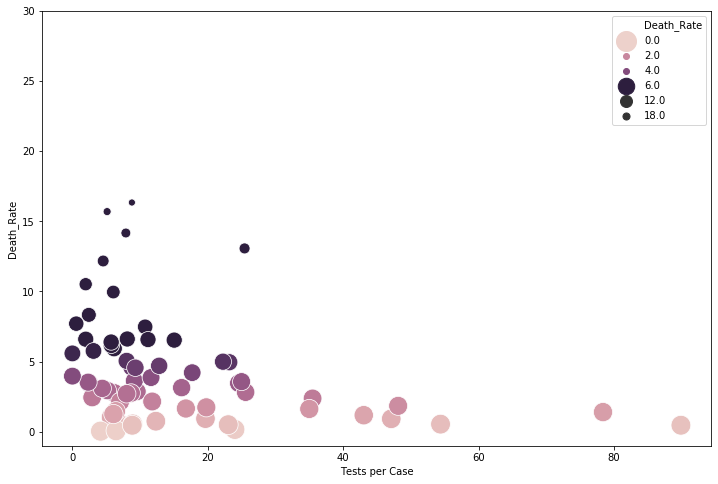

In [15]:
#Now we will evaluate correlation of death rate on number of tests conducted/confirmed case
#Plotting Death_Rate vs Number of Tests conducted/Confirmed Case
Country_df["Tests per Case"] = Country_df["Total Tests"]/Country_df["Confirmed"]

plt.figure(figsize=(12, 8))
sns.scatterplot( x= "Tests per Case", y="Death_Rate", data = Country_df,hue="Death_Rate", size = "Death_Rate",
    sizes=(400,50), hue_norm=(0, 6),cmap="colorwarm")
plt.ylim(-1,30)

##### Observations:
1. With this scatter plot , we can see that the countries with maximum testing (>40 tests) are always in low death rate (<3%)
2. And countries with <20 tests are always in high death range (>5%). 
3. Hence we can say that true death rate must lie in 1-3 % range. 

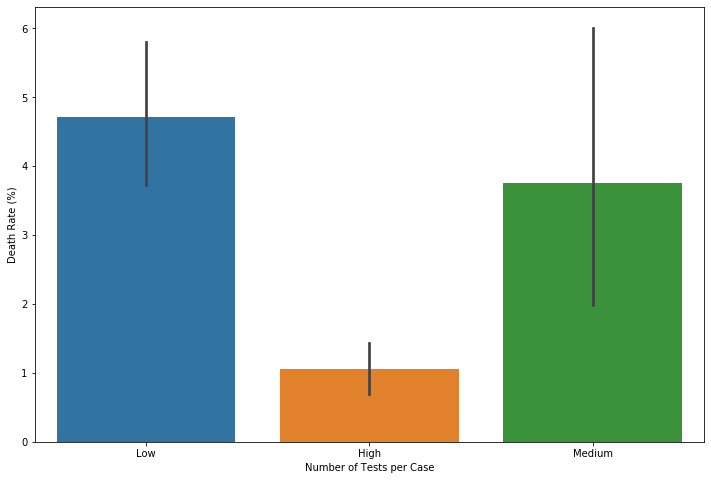

In [16]:
#Now catergorizing the country as low test (0) , medium testing(1) and high testing(2)
Country_df["Testing_Label"]= "None"

for i in Country_df.index:
    if Country_df["Tests per Case"][i]< 20:
        Country_df["Testing_Label"][i] = "Low"
    if Country_df["Tests per Case"][i]> 20:
        if Country_df["Tests per Case"][i]< 40:
            Country_df["Testing_Label"][i] = "Medium"  
        if Country_df["Tests per Case"][i]> 40:
            Country_df["Testing_Label"][i] = "High" 
        
plt.figure(figsize=(12, 8))
sns.barplot( x= "Testing_Label",y="Death_Rate" ,data = Country_df)
plt.ylabel('Death Rate (%)')
plt.xlabel('Number of Tests per Case');
plt.show()

##### Observations:
1. With this bar plot , we see that the countries with low testing(<20 tests/case) have high death rate (5%)
2. And countries with >5 tests have medium death rate (~3%). 
3. And countries with good testing >50 have 1.5% testing rate( this should be closest to True positive rate)

In [17]:
#Printing Avg. death rate
col = Country_df["Testing_Label"].unique()
for i in col:
    print("Avg death rate in",i," testing countries is ",Country_df[Country_df["Testing_Label"]==i]["Death_Rate"].mean())

Avg death rate in Low  testing countries is  4.713927829982885
Avg death rate in High  testing countries is  1.0610151808094999
Avg death rate in Medium  testing countries is  3.7553956794483936


### Correlation of True Death Rate with Population Age


In [18]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 4 columns):
Country                     213 non-null object
Fraction age 0-14 years     176 non-null float64
Fraction age 15-64 years    176 non-null float64
Fraction age 65+ years      176 non-null float64
dtypes: float64(3), object(1)
memory usage: 6.7+ KB


In [19]:
#Also we can drop rows from age dataset with null values
df_age.dropna(axis=0,how="any",inplace=True)
df_age.isnull().sum()
#Now age dataset has no null values

Country                     0
Fraction age 0-14 years     0
Fraction age 15-64 years    0
Fraction age 65+ years      0
dtype: int64

In [20]:
#Now combining our COVID dataset with population fraction dataset
df_age.rename(columns={"Country": "Country Name"},inplace=True)
df_new = Country_df.merge(df_age,on="Country Name")
df_new.head()

,Country Name,Confirmed,Deaths,Recovered,Active Cases,Death_Rate,Total Tests,Population,Tests per Case,Testing_Label,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,USA,1998658.0,91981.0,356383.0,1550294.0,5.933133,12300744.0,330774664,6.154502,Low,0.189,0.657,0.154
1,Russia,363609.0,2722.0,70209.0,290678.0,0.936431,7147014.0,145927292,19.655768,Low,0.176,0.682,0.142
2,Spain,502855.0,27709.0,196958.0,278188.0,9.960530,3037840.0,46752703,6.041185,Low,0.147,0.659,0.194
3,Brazil,372680.0,16853.0,100459.0,255368.0,6.599496,735224.0,212380932,1.972802,Low,0.217,0.697,0.086
4,Italy,385219.0,32007.0,127326.0,225886.0,14.169537,3041366.0,60471924,7.895161,Low,0.135,0.635,0.230


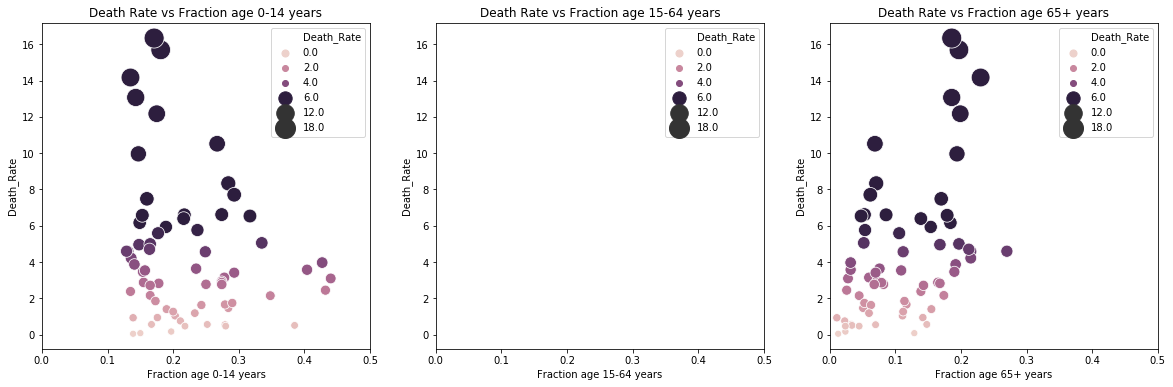

In [21]:
#Now we will evaluate correlation of death rate with age 

cols =["Fraction age 0-14 years","Fraction age 15-64 years","Fraction age 65+ years"]
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=[20,6])
for i in range(0,len(cols)):
    axes[i]=sns.scatterplot( x= cols[i], y="Death_Rate", data = df_new,hue="Death_Rate", size = "Death_Rate",    sizes=(50,400), hue_norm=(0, 6),cmap="accent",ax=axes[i])
    axes[i].set_title("Death Rate vs "+cols[i])
    axes[i].set_xlim([0, 0.5])

##### Observations:
1. Clearly an upward trend in death rate can be seen in countries with higher fraction of old people.
2. Countries with >15% old population are seein >8% of death rate. 
3. Countries with <5% are seeing ~4% of death rate.

## Estimating True Infection Rate and True fatality Ratio for all Countries

##### We can assume that COVID true infection rate (TIR) and True Fatality Ration (TFR) are dependent on following criteria:  
    a. Testing conducted per case  
    b. Fraction of old people in the country  
    


##### Observation:
a. For countries with >50 tests Death_rate is close to TIR ~ 1.41%.   


In [22]:
#Now we will calculate mean old population in those countries.
b = df_new.groupby("Testing_Label")["Country Name"].get_group("High").reset_index(drop=True)
a = df_new.groupby("Testing_Label")["Fraction age 65+ years"].get_group("High").mean()

print("Countries with high testing rate are\n",b , "\n","Avg. old population fraction is ",a*100,"%")

Countries with high testing rate are
 0           UAE
1     Australia
2    Kazakhstan
3    Azerbaijan
4      Thailand
5    Uzbekistan
Name: Country Name, dtype: object 
 Avg. old population fraction is  7.583333333333334 %


## Calculating True Confirmed Cases and True Infection Rate

In [24]:
# Now Infection rate in high testing countries will be close to TIR~ 1.1% 
# Frac old population >65+ in high testing countries is  ~ 7.58%
#Assuming a linear relationship
#True Infection rate (TIR) = (frac old population * 1.1%)/7.58%
# True Cases = Deaths/TIR

df_new["True Infection Rate(%)"] = (df_new["Fraction age 65+ years"]*1.1)/(7.58/100)

df_new["True Cases"] = df_new["Deaths"]*100/df_new["True Infection Rate(%)"]

df_new["% of population infected"] = df_new["True Cases"]*100/df_new["Population"]


In [25]:
df_new
sorted_new = df_new.sort_values("True Cases", ascending=False).reset_index(drop=True)
sorted_new.head(10).style.background_gradient(cmap='coolwarm')

,Country Name,Confirmed,Deaths,Recovered,Active Cases,Death_Rate,Total Tests,Population,Tests per Case,Testing_Label,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years,True Infection Rate(%),True Cases,% of population infected
0,USA,1.99866e+06,91981,356383,1.55029e+06,5.93313,1.23007e+07,330774664,6.1545,Low,0.189,0.657,0.154,2.23483,4.1158e+06,1.24429
1,Brazil,372680,16853,100459,255368,6.5995,735224,212380932,1.9728,Low,0.217,0.697,0.086,1.24802,1.35038e+06,0.635828
2,France,269894,28239,61728,179927,15.6947,1.38463e+06,65256826,5.13028,Low,0.181,0.622,0.197,2.85884,987779,1.51368
3,Spain,502855,27709,196958,278188,9.96053,3.03784e+06,46752703,6.04118,Low,0.147,0.659,0.194,2.8153,984228,2.10518
4,Italy,385219,32007,127326,225886,14.1695,3.04137e+06,60471924,7.89516,Low,0.135,0.635,0.23,3.33773,958945,1.58577
5,Iran,225210,7057,95661,122492,5.76119,701640,83862642,3.11549,Low,0.237,0.709,0.054,0.783641,900540,1.07383
6,Mexico,87725,5177,33329,49219,10.5183,172294,128770253,1.96402,Low,0.267,0.665,0.069,1.00132,517018,0.401504
7,India,142717,3156,39233,100328,3.14568,2.30279e+06,1378381772,16.1354,Low,0.278,0.662,0.06,0.870712,362462,0.0262962
8,Turkey,266341,4171,111577,150593,2.76972,1.65014e+06,84230075,6.19557,Low,0.25,0.669,0.082,1.18997,350512,0.416136
9,Belgium,79296,9080,14657,55559,16.343,696840,11583739,8.78783,Low,0.171,0.643,0.186,2.69921,336395,2.90403


In [62]:
#Plotting top 20 countries with most Confirmed Cases 
countries=[]
reported_cases=[]
calculated_cases=[]
reported_death_rate=[]
calculated_death_rate=[]

for i in range(0,19):
    countries.append(df_new["Country Name"][i])
    reported_cases.append(df_new["Confirmed"][i])
    calculated_cases.append(df_new["True Cases"][i])
    reported_death_rate.append(df_new["Death_Rate"][i])
    calculated_death_rate.append(df_new["True Infection Rate(%)"][i])

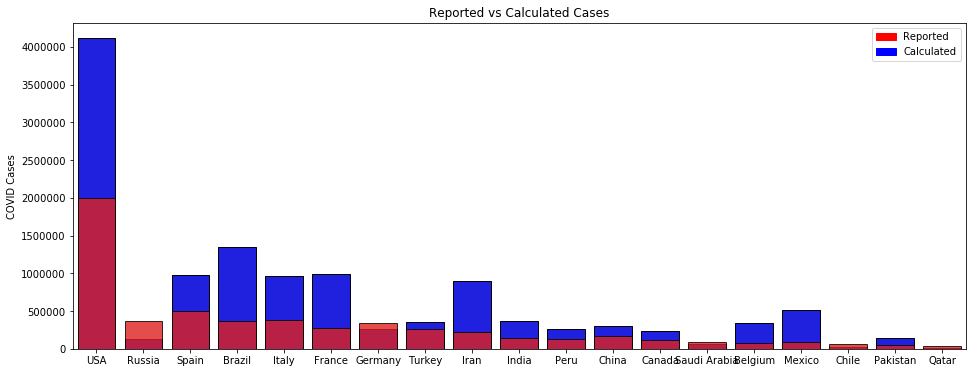

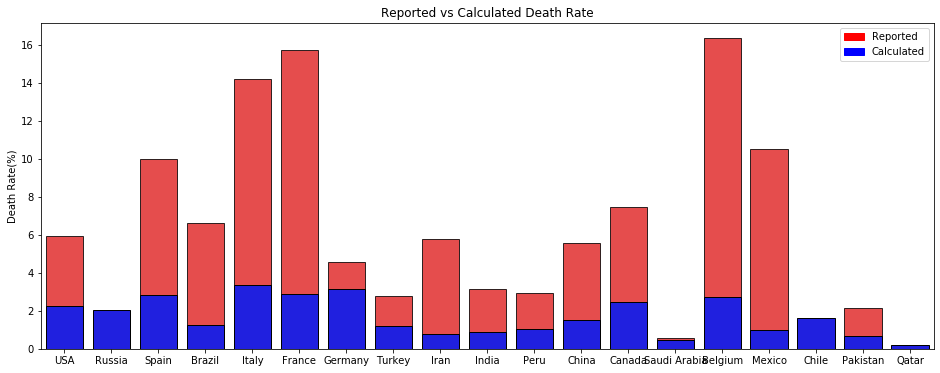

In [68]:
plt.figure(figsize=(16,6))
ax1=sns.barplot(x=countries, y=calculated_cases,color="Blue",edgecolor="Black")
ax1=sns.barplot(x=countries, y=reported_cases,color="Red",alpha=0.8, edgecolor="Black")
colors = {'Reported':'red', 'Calculated':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title('Reported vs Calculated Cases')
plt.ylabel("COVID Cases")
plt.show()

plt.figure(figsize=(16,6))
ax2=sns.barplot(x=countries, y=reported_death_rate,color="Red",alpha=0.8, edgecolor="Black")
ax2=sns.barplot(x=countries, y=calculated_death_rate,color="Blue",edgecolor="Black")
colors = {'Reported':'red', 'Calculated':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title('Reported vs Calculated Death Rate')
plt.ylabel("Death Rate(%)")
plt.show()



## Observations for True Cases and True Infection Rate:
1. For Countries with lower testing label (Ex: USA , Iran) . True case numbers are very high than reported. 
2. For Countries with medium and high testing(Ex: Russia,Germany). True numbers are close to reported numbers. 
3. All countries have TIR in range of 1% to 4%(which is close to actual mean value)
4. Many countries (Ex: France , Italy, Spain , Iran) have overpredicted the Death Rate values by huge margin. 

## Overall Remarks:
1. Retrieved data from worldometer database for month of April and May
2. Dropped irrelevant cols such as Serious or critical and also dropped few null rows. 
3. Imputed values in Deaths and Total tests columns. 
3. With Data Visualization found below observations:
    a. We can observe that death rate varies from 16 % to 0.5% for most of the countries.
    b. Highest Death rate found in  Belgium, France and Italy , while lowest Death Rate found in Qatar, Singapore, Bahrain.
    c. Found High testing countries have Death rate close to TIR~1.1%
    d. Found Countries with >15% old population are seein >8% of death rate.
4. Correlated testing done/confirmed case and divided countries by testing label. 
5. Evaluated corelation of age with death rate and found positive corelation of old population with death rate. 
4. Asumming linear relationship , calculated TIR on the basis of deaths reported and fraction of old age. 
5. Found that many countries are underreporting cases and over reporting Death Rate

In [70]:
#Saving prediction to csv file
covid_age_df = pd.DataFrame({'Country': sorted_new["Country Name"],'True Cases': sorted_new["True Cases"],"True Infection Rate":sorted_new["True Infection Rate(%)"]})
print(covid_age_df)
covid_age_df.to_csv("True COVID parameters estimation.csv",index=False)

         Country    True Cases  True Infection Rate
0            USA  4.115797e+06             2.234828
1         Brazil  1.350378e+06             1.248021
2         France  9.877786e+05             2.858839
3          Spain  9.842278e+05             2.815303
4          Italy  9.589449e+05             3.337731
5           Iran  9.005397e+05             0.783641
6         Mexico  5.170179e+05             1.001319
7          India  3.624618e+05             0.870712
8         Turkey  3.505120e+05             1.189974
9        Belgium  3.363949e+05             2.699208
10         China  3.012497e+05             1.538259
11       Ecuador  2.716571e+05             1.030343
12          Peru  2.669270e+05             1.044855
13       Germany  2.603482e+05             3.120053
14        Canada  2.368041e+05             2.467018
15     Indonesia  1.548504e+05             0.769129
16           UAE  1.403240e+05             0.159631
17      Pakistan  1.382776e+05             0.653034
18        Ru